In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import numpy as np


In [2]:
import pandas as pd
import os
from PIL import Image
import numpy as np

# Correct base directory for your processed images
base_dir = r"C:\Users\cparker\OneDrive - WRHI\Andrew\FilesReport_UJReport_2024-03-14_1413 (1)\FilesReport_UJReport_2024-03-14_1413\documents\processed_images"

# Assuming you have 'image_measurements.csv' in the same directory as your processed images
csv_file = os.path.join(base_dir, 'image_measurements.csv')
df = pd.read_csv(csv_file)

# Function to load images based on the corrected path
def load_images(df, base_dir):
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(base_dir, row['image_filename'])
        try:
            with Image.open(image_path) as img:
                img = img.resize((128, 128))  # Resize for uniformity
                img_array = np.array(img)
                images.append(img_array)
        except FileNotFoundError:
            print(f"File not found: {image_path}")
    return np.array(images)

images = load_images(df, base_dir)
onsd_measurements = df['onsd_measurement'].values

# Normalize images
images = images / 255.0

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(images, onsd_measurements, test_size=0.2, random_state=42)


In [3]:
# Ensure the input shape is correct for the pre-trained model, e.g., (224, 224, 3) for MobileNet
X_train_resized = np.array([tf.image.resize(image, (224, 224)).numpy() for image in X_train])
X_test_resized = np.array([tf.image.resize(image, (224, 224)).numpy() for image in X_test])


In [4]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model


In [5]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1)  # Regression output for ONSD measurement
])


In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])


In [7]:
history = model.fit(X_train_resized, y_train, epochs=30, validation_data=(X_test_resized, y_test))


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 24.3920 - mean_absolute_error: 4.9033 - val_loss: 23.3662 - val_mean_absolute_error: 4.7274
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 21.4423 - mean_absolute_error: 4.5627 - val_loss: 20.2353 - val_mean_absolute_error: 4.3875
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 18.9935 - mean_absolute_error: 4.2991 - val_loss: 17.3957 - val_mean_absolute_error: 4.0540
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 16.5729 - mean_absolute_error: 3.9648 - val_loss: 14.8398 - val_mean_absolute_error: 3.7279
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 13.3171 - mean_absolute_error: 3.5540 - val_loss: 12.5654 - val_mean_absolute_error: 3.4110
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 999ms/step - loss: 11.1725 - mean_absolute_error: 3.2166 - val_loss: 10.5795 - val_mean_absolute_error: 3.1072
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 960ms/step - loss: 9.7220 - mean_absolute_error: 2.9585 - val_loss: 8.8481

In [8]:
test_loss, test_mae = model.evaluate(X_test_resized, y_test, verbose=2)
print(f"Test loss: {test_loss}, Test MAE: {test_mae}")


2/2 - 2s - 778ms/step - loss: 1.0790 - mean_absolute_error: 0.9500
Test loss: 1.0789872407913208, Test MAE: 0.950017511844635


In [9]:
predictions = model.predict(X_test_resized).flatten()


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 0.9500175801719107
Mean Squared Error (MSE): 1.3260867490777117
Root Mean Squared Error (RMSE): 1.1515584002028345


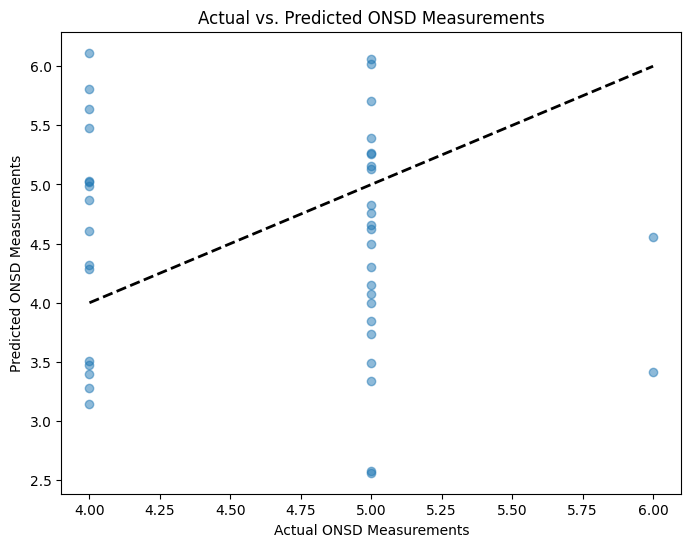

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual ONSD Measurements')
plt.ylabel('Predicted ONSD Measurements')
plt.title('Actual vs. Predicted ONSD Measurements')
plt.show()


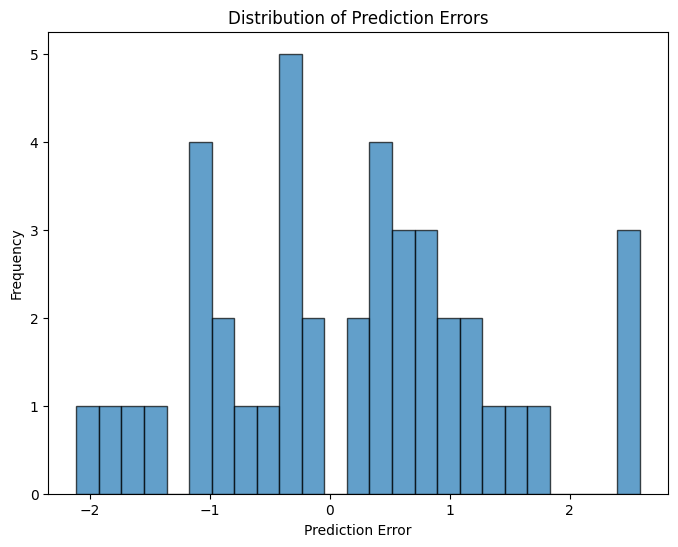

In [12]:
errors = y_test - predictions

plt.figure(figsize=(8, 6))
plt.hist(errors, bins=25, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()


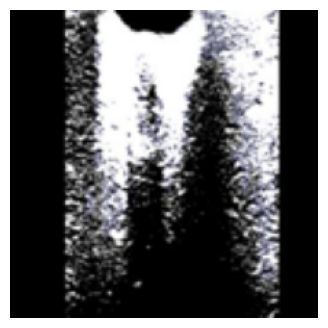

Index: 0
Actual ONSD Measurement: 6
Predicted ONSD Measurement: 3.41450834274292


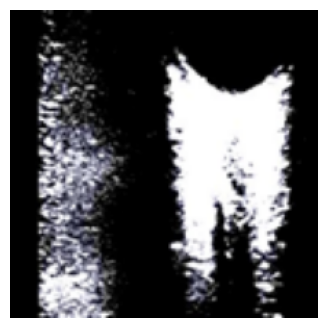

Index: 1
Actual ONSD Measurement: 4
Predicted ONSD Measurement: 5.0323381423950195


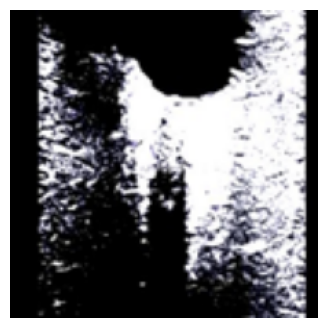

Index: 2
Actual ONSD Measurement: 4
Predicted ONSD Measurement: 3.504213571548462


In [13]:
# Function to display a specific test image, its actual measurement, and the model's prediction
def display_comparison(index):
    plt.figure(figsize=(6, 4))
    img = tf.keras.preprocessing.image.array_to_img(X_test_resized[index])
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    actual = y_test[index]
    pred = predictions[index]
    print(f"Index: {index}")
    print(f"Actual ONSD Measurement: {actual}")
    print(f"Predicted ONSD Measurement: {pred}")

# Display comparison for the first three test images
for i in range(3):
    display_comparison(i)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with desired augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    rotation_range=20,  # Rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shearing
    zoom_range=0.2,  # Zooming
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Assuming X_train and y_train are your images and labels
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Note: For validation data, usually, we only apply rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow(X_test, y_test, batch_size=32)


In [15]:
from tensorflow.keras import layers, models

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
])

# Example model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Now, you can train your model using X_train and y_train directly.
# The data augmentation will be applied on the fly during training.


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'